# Task 4

Find the lowest eigenvalue of the following matrix:

$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0  \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

using VQE-like circuits, created by yourself from scratch.

# 1) Decomposing the desired matrix into pauli operators

Since we want to measure a VQE-like circuit, we need to decompose the matrix into their pauli components. We have that the pauli matrices are:

$$
\sigma_x = \begin{pmatrix}
    0 & 1 \\
    1 & 0
    \end{pmatrix} \hspace{1em} , \hspace{1em}  \sigma_y = \begin{pmatrix}
    0 & -i \\
    i & 0
    \end{pmatrix} \hspace{1em} , \hspace{1em}  \sigma_z = \begin{pmatrix}
    1 & 0 \\
    0 & -1
    \end{pmatrix}
$$

Thus to get the pauli component of a $2^N$ x $2^N$ matrix $A$, as stated on [stackoverflow](https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis), we have:

$$
A = \sum_{ij} \frac{1}{4} h_{ij} \hspace{0.5em} \sigma_i \otimes \sigma_j
$$

And the components $h_{ij}$ are:

$$
h_{ij} = \frac{1}{4} \mathrm{Tr} \bigg[ (\sigma_i \otimes \sigma_j) \cdot A \bigg]
$$

Therefore we create a function `get_components_from_matrix` that does this decomposition for us.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit

In [2]:
# The matrix that we want to decompose
A = np.array([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])

# Defining Pauli Matrices
pauli_x = np.array([[0,1],[1,0]]) ; pauli_y = np.array([[0,1j],[-1j,0]]) ; pauli_z = np.array([[1,0],[0,-1]])

basis = {'I': np.eye(2),
     'X': pauli_x,
     'Y': pauli_y,
     'Z': pauli_z}

In [3]:
from itertools import product

def get_components_from_matrix(A, basis):
    """ Decompose a matrix on a given basis, in our case
    we decompose in the pauli basis {I,X,Y,Z}.
    
    Args:
        A (list, np.array): Matrix that you want to decompose.
        basis (dict): dictionary with name of the basis as keys
        and the basis matrix as values.
    
    Output:
        components_dict (dict): Dictionary with the basis name as keys
        and component as values.
    """
    
    assert len(A) == len(A[0]), "your matrix is not square"
    assert not np.abs(int(np.log2(len(A))) - np.log2(len(A))) > 0, "the lenght of your matrix is not a power of 2"
    
    repeat_times = int(np.log2(len(A)))
    components_dict = {}
    
    for (name_1, pauli_1),(name_2, pauli_2) in product(basis.items(), repeat=repeat_times):           
        components_dict[name_1 + name_2] = np.trace(1/4.*np.kron(pauli_1,pauli_2) @ A)
    
    return { key : val for key,val in components_dict.items() if val != 0}

In [4]:
components = get_components_from_matrix(A, basis)

print("Decomposition:")
for name, comp in components.items():
    print(f"  {name} : {comp}")

Decomposition:
  II : 0.5
  XX : -0.5
  YY : (-0.5+0j)
  ZZ : 0.5


In [5]:
print("Result of the decomposition of A:")
decomp = 0.5*np.kron(np.eye(2), np.eye(2)) - 0.5*np.kron(pauli_x, pauli_x) - 0.5*np.kron(pauli_y, pauli_y)  + 0.5*np.kron(pauli_z, pauli_z)
print(f"""{decomp}""")

Result of the decomposition of A:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


Now we know that the desired matrix, has the following pauli decomposition:

$$
A = 0.5 I \otimes I \ - \ 0.5 \sigma_x \otimes \sigma_x \ - \ 0.5 \sigma_y \otimes \sigma_y \ + \ 0.5 \sigma_z \otimes \sigma_z
$$

# 2) Creating VQE circuit

Now we want to construct the VQE circuti and measure the pauli factors in order to get the lowest eigenvalue of $A$. This is done in three parts:
- 1) Construct the VQE Ansatz, which is a parametrized quantum circuit;
- 2) Construct XX, YY, and ZZ measurements;
- 3) Vary VQE Ansatz parameters and measure the eigenvalue.

## 2.1) Creating Ansatz

In order to create the Variational Ansatz, we need to create a parametrized circuit. Here I chose to use Qiskit, therefore we need to use `parameter` from the `qiskit.circuit` library. 

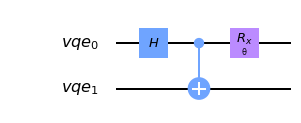

In [6]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import execute, Aer
from qiskit.circuit import Parameter

theta = Parameter('θ')

qr = QuantumRegister(2, name='vqe')
qc = QuantumCircuit(qr)
qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.rx(theta, qr[0])
qc.draw('mpl')

## 2.2) Constructing XX, YY, and ZZ measurements

After creating our Ansatz, we need to measure the expected values of our pauli variables: XX, YY, and ZZ. The ZZ measurement is the easiest one, because the measurements are given on the computational basis, which is the same as saying that it is in the Z basis. For XX and YY measurements we need to make a change of basis in order to measure it, this will be explained in their respective sections.

### 2.2.1) Constructing ZZ measurement

Since the standard measurements are already in the ZZ basis, we only need to copy the circuit and use the `.measure_all()` method. Below there is a example of a circuit doing the ZZ measurement.

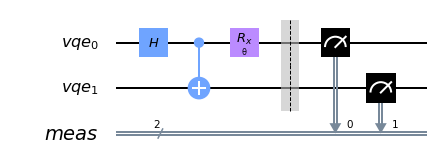

In [8]:
def measure_zz_circuit(circuit: qiskit.QuantumCircuit):
    """Measure the ZZ Component of the variational circuit.
    Args:
        circuit (qiskit.QuantumCircuit): Circuit that you want to measure the ZZ
        Component.
    
    Outputs:
        zz_meas (qiskit.QuantumCircuit): Circuit with ZZ measurement.
    
    """
    zz_meas = circuit.copy()
    zz_meas.measure_all()
    return zz_meas

zz_meas = measure_zz_circuit(qc)
zz_meas.draw('mpl')

Now that we have created the ZZ circuit, we need a way to measure it. In this case we will do a sweep over the parametric variable $\theta$ and get the expected values for each value of the parameter.

In order to calculate the expected value, we need to see how a ZZ measurement will affect a arbitrary qubit:

$$
Z \otimes Z(a ∣00\rangle + b∣01\rangle + c∣10 \rangle + d∣11\rangle ) =  a∣00 \rangle − b∣01\rangle − c∣10\rangle + d∣11\rangle
$$

Thus in order to have the expectation value of Z, we have:
$$
\langle \psi | Z\otimes Z | \psi \rangle = \mathrm{Pr}(00) - \mathrm{Pr}(01) - \mathrm{Pr}(10) + \mathrm{Pr}(11)
$$

Where $\mathrm{Pr}(ij)$ is the probability of measuring the variable $ij$. In order to obtain the probabilities, we need to fill in a zero when the probability doesn't show up because qiskit will not put this probability in the dictionary.

In [9]:
def measure_zz(given_circuit: qiskit.QuantumCircuit, 
               theta_range: [list, np.array], 
               num_shots: int = 10000):
    """ Measure the ZZ expected value for a given_circuit.
    
    Args:
        given_circuit (qiskit.QuantumCircuit): The parametrized circuit that you 
        want to calculate the ZZ expected value.
        theta_range (Union[list, np.array]): Range of the parameter that you want
        to sweep.
        num_shots (int): Number of shots for each circuit run. (default=10000)
    
    Returns:
        zz (np.array): Expected values for each parameter.
    """
    zz_meas = measure_zz_circuit(given_circuit)

    simulator = qiskit.Aer.get_backend('qasm_simulator')
    
    job = execute(zz_meas,
              backend= simulator,
              shots= num_shots,
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])
    
    counts = job.result().get_counts()

    zz = []
    for count in counts:        
        # Fill if the ij doesn't show up
        if '00' not in count:
            count['00'] = 0
        if '01' not in count:
            count['01'] = 0
        if '10' not in count:
            count['10'] = 0
        if '11' not in count:
            count['11'] = 0        
        
        # Get total counts in order to obtain the probability
        total_counts = count['00'] + count['11'] + count['01'] + count['10']
        # Get counts for expected value
        zz_meas = count['00'] + count['11'] - count['01'] - count['10']
        # Append the probability
        zz.append(zz_meas / total_counts)
    
    return np.array(zz)

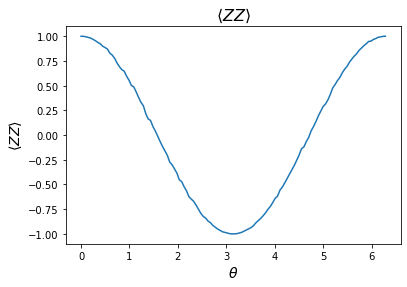

In [10]:
theta_range = np.linspace(0, 2 * np.pi, 128)
zz = measure_zz(qc, theta_range)
plt.plot(theta_range, zz);
plt.title(r"$\langle ZZ \rangle$", fontsize=16)
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel(r"$\langle ZZ \rangle$", fontsize=14)
plt.show()

### 2.2.2) Constructing YY measurement

In order to get the expectation value for the YY measurement, we need a change of basis because the measurement are only made on the Z basis. We use the following identity: $Y = (HS^\dagger)^\dagger Z H S^\dagger$, thus the YY expected value is:

$$
\langle \psi | Y  | \psi \rangle = (\langle \psi |(H S^\dagger)^\dagger) Z  (H S^\dagger| \psi \rangle) \equiv \langle \tilde \psi | Z | \tilde \psi \rangle
$$

Therefore, we need to add $S^\dagger H$ and do a Z measurement (just as the previous section) where we want to measure the $Y$ expected value.

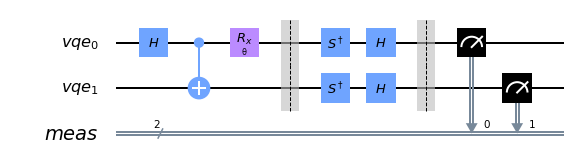

In [11]:
def measure_yy_circuit(circuit: qiskit.QuantumCircuit):
    """Measure the YY Component of the variational circuit.
    Args:
        given_circuit (qiskit.QuantumCircuit): Circuit that you want to measure the YY
        Component.
    
    Outputs:
        yy_meas (qiskit.QuantumCircuit): Circuit with YY measurement.
    
    """
    yy_meas = circuit.copy()
    yy_meas.barrier(range(2))
    yy_meas.sdg(range(2))    
    yy_meas.h(range(2))    
    yy_meas.measure_all()
    return yy_meas

yy_meas = measure_yy_circuit(qc)
yy_meas.draw('mpl')

In [12]:
def measure_yy(given_circuit: qiskit.QuantumCircuit, 
               theta_range: [list, np.array], 
               num_shots: int = 10000):
    """ Measure the YY expected value for a given_circuit.
    
    Args:
        given_circuit (qiskit.QuantumCircuit): The parametrized circuit that you 
        want to calculate the YY expected value.
        theta_range (Union[list, np.array]): Range of the parameter that you want
        to sweep.
        num_shots (int): Number of shots for each circuit run. (default=10000)
    
    Returns:
        yy (np.array): Expected values for each parameter.
    """
    
    yy_meas = measure_yy_circuit(given_circuit)
    
    simulator = Aer.get_backend('qasm_simulator')
    
    job = execute(yy_meas,
              backend= simulator,
              shots=num_shots,
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])
    
    counts = job.result().get_counts()

    yy = []
    for count in counts:        
        if '00' not in count:
            count['00'] = 0
        if '01' not in count:
            count['01'] = 0
        if '10' not in count:
            count['10'] = 0
        if '11' not in count:
            count['11'] = 0        
        
        total_counts =  count['00'] + count['11'] + count['01'] + count['10']
        
        yy_meas =  count['00'] + count['11'] - count['01'] - count['10']
        yy.append(yy_meas / total_counts)
    
    return np.array(yy)

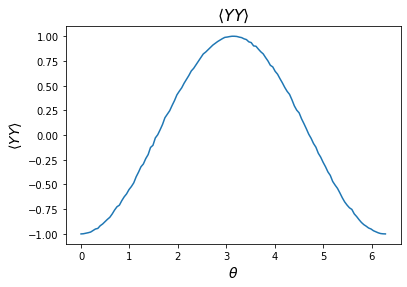

In [13]:
theta_range = np.linspace(0, 2 * np.pi, 128)
yy = measure_yy(qc, theta_range)
plt.plot(theta_range, yy)
plt.title(r"$\langle YY \rangle$", fontsize=16)
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel(r"$\langle YY \rangle$", fontsize=14)
plt.show()

### 2.2.3) Constructing XX measurement

Just as the YY measurement, we need to use a identity in order to change from the X basis to the Z basis in order to do the measurement: $X = H Z H $, thus the YY expected value is:

$$
\langle \psi | Y  | \psi \rangle = (\langle \psi |H) Z  (H | \psi \rangle) \equiv \langle \tilde \psi | Z | \tilde \psi \rangle
$$

Therefore, we need to add $H$ and do a Z measurement where we want to measure the $X$ expected value.

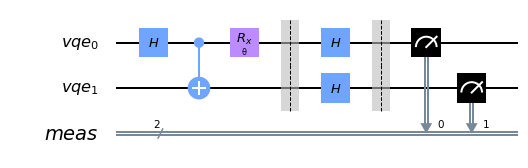

In [14]:
def measure_xx_circuit(circuit: qiskit.QuantumCircuit):
    """Measure the XX Component of the variational circuit.
    
    Args:
        circuit (qiskit.QuantumCircuit): Circuit that you want to measure the XX
        Component.
    
    Outputs:
        xx_meas (qiskit.QuantumCircuit): Circuit with XX measurement.
    
    """
    xx_meas = circuit.copy()  
    xx_meas.barrier(range(2))
    xx_meas.h(range(2)) 
    xx_meas.measure_all()    
    return xx_meas

xx_meas = measure_xx_circuit(qc)
xx_meas.draw('mpl')

In [15]:
def measure_xx(given_circuit: qiskit.QuantumCircuit, 
               theta_range: [list, np.array], 
               num_shots: int = 10000):
    """ Measure the XX expected value for a given_circuit.
    
    Args:
        given_circuit (qiskit.QuantumCircuit): The parametrized circuit that you 
        want to calculate the XX expected value.
        theta_range (Union[list, np.array]): Range of the parameter that you want
        to sweep.
        num_shots (int): Number of shots for each circuit run. (default=10000)
    
    Returns:
        xx (np.array): Expected values for each parameter.
    """
    xx_meas = measure_xx_circuit(given_circuit)    

    simulator = Aer.get_backend('qasm_simulator')
    
    job = execute(xx_meas,
              backend= simulator,
              shots=num_shots,
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])
    
    counts = job.result().get_counts()

    xx = []
    
    for count in counts:        
        if '00' not in count:
            count['00'] = 0
        if '01' not in count:
            count['01'] = 0
        if '10' not in count:
            count['10'] = 0
        if '11' not in count:
            count['11'] = 0         
            
        total_counts = count['00'] + count['11'] + count['01'] + count['10']
        
        xx_meas = count['00'] + count['11'] - count['01'] - count['10']
        xx.append(xx_meas / total_counts)
    
    return np.array(xx)

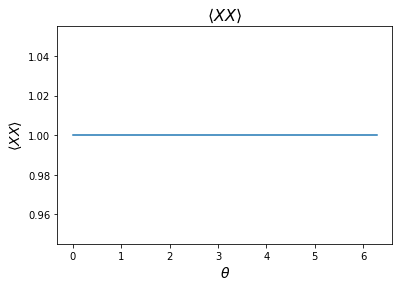

In [16]:
theta_range = np.linspace(0, 2 * np.pi, 128)
xx = measure_xx(qc, theta_range)
plt.plot(theta_range, xx)
plt.title(r"$\langle XX \rangle$", fontsize=16)
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel(r"$\langle XX \rangle$", fontsize=14)
plt.show()

One fun fact is that since the ansatz consists of rotations on the X axis, i.e. $H$ and $R_X$, the expected value of the XX operator is constant, if the ansatz was only rotations on the Y axis, the YY operator would be constant, and so on. This shows that our ansatz is not searching through all the Hilbert space and only a portion of it, thus we hope that our solution is in this portion, if it is not we should search for another ansatz.

## 2.3) Getting the eigenvalue

Now that we constructed XX, YY, and ZZ expected values, we can measure them given our defined ansatz and apply for the pauli decomposition of the given matrix, which is: 

$$
A = 0.5 I \otimes I \ - \ 0.5 \sigma_x \otimes \sigma_x \ - \ 0.5 \sigma_y \otimes \sigma_y \ + \ 0.5 \sigma_z \otimes \sigma_z
$$

$I \otimes I$ measurements are always 1, because of the normalization of the quantum state, i.e. $\langle \psi | \psi \rangle = 1$, all other values comes from what is measured varying the parameters of the ansatz.

In [17]:
def get_eigenvalue(circuit, theta_range, num_shots = 10000):
    
    xx = measure_xx(circuit, theta_range, num_shots = num_shots)
    yy = measure_yy(circuit, theta_range, num_shots = num_shots)
    zz = measure_zz(circuit, theta_range, num_shots = num_shots)    
    
    energy = 0.5*1 \
             - 0.5*xx \
             - 0.5*yy \
             + 0.5*zz
    
    return energy

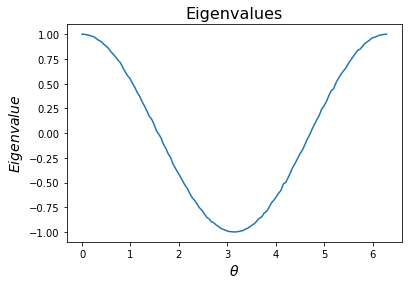

In [18]:
theta_range = np.linspace(0, 2 * np.pi, 128)
eigenvalues = get_eigenvalue(qc, theta_range)
plt.plot(theta_range, eigenvalues)
plt.title(r"Eigenvalues", fontsize=16)
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel(r"$Eigenvalue$", fontsize=14)
plt.show()

In [19]:
print(f"Smallest eigenvalue from VQE: {np.round(np.min(eigenvalues),4)} with theta = {np.round(theta_range[np.argmin(eigenvalues)], 2)}")
print(f"Smallest eigenvalue calculated classically = {np.round(np.min(np.linalg.eigh(A)[0]),4)}")
print(f"Error between classical and quantum: {np.round(np.abs(np.min(eigenvalues) - np.min(np.linalg.eigh(A)[0])), 4)}")

Smallest eigenvalue from VQE: -0.9998 with theta = 3.17
Smallest eigenvalue calculated classically = -1.0
Error between classical and quantum: 0.0002


--------------------------------------------

# References

1) [Qiskit Documentation](https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html)

2) [Quantum Computing: An applied Approach - Hidary](https://www.springer.com/gp/book/9783030239213)

3)[Qiskit Summer School](https://www.youtube.com/watch?v=Rs2TzarBX5I&list=PLOFEBzvs-VvrXTMy5Y2IqmSaUjfnhvBHR)

In [20]:
from qiskit.tools.jupyter import *
%qiskit_version_table